<a href="https://www.kaggle.com/code/mstasyuk/simpsons-classification?scriptVersionId=132972103" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Loading Data, Imports

In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

In [2]:
%%capture
%%bash
wget "https://www.dropbox.com/s/a08z03ih16eoiwv/mlflow.db?dl=0" -O mlflow.db
wget "https://www.dropbox.com/s/wfi55wumsubjjb6/mlruns.zip?dl=0" -O mlruns.zip
unzip mlruns.zip -d /

In [3]:
!wget "https://www.dropbox.com/s/2sxx1f5x4f353tq/journey-springfield-augmented.zip?dl=0" -O journey-springfield.zip --quiet
!mkdir data

In [4]:
%%capture
!unzip journey-springfield.zip -d ./data 

In [5]:
%%bash
mv ./data/journey-springfield/testset ./data/test
mv ./data/journey-springfield/train/simpsons_dataset ./data/
rmdir ./data/journey-springfield/train
mv ./data/simpsons_dataset ./data/train
rm -r data/journey-springfield

In [6]:
# Check if data exists
![ -d "./data/train" ] && echo "Directory ./data/train exists."
![ -d "./data/test" ] && echo "Directory ./data/testset exists."
![ -d "./mlruns" ] && echo "Directory ./mlruns exists."
![ -f "./mlflow.db" ] && echo "mlflow.db exists."

Directory ./data/train exists.
Directory ./data/testset exists.
Directory ./mlruns exists.
mlflow.db exists.


In [7]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt

import mlflow

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import torchmetrics
import time
import os
import copy
import pickle

from sklearn.model_selection import train_test_split

cudnn.benchmark = True

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [8]:
# Choose processor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [66]:
RESCALE_SIZE = 224
# Define simple transforms
augmentations = [
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.5)),
    transforms.Resize(35, interpolation=transforms.InterpolationMode.NEAREST_EXACT),
    transforms.RandomHorizontalFlip(),
]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice(augmentations),
        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [67]:
data_dir = './data/'

In [68]:
# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
                  for x in ['train', 'test']}

In [69]:
# Split train data to train and val subsets

VAL_SIZE = 0.2
train_idx, validation_idx = train_test_split(np.arange(len(image_datasets['train'])),
                                             test_size=VAL_SIZE,
                                             random_state=1,
                                             shuffle=True,
                                             stratify=image_datasets['train'].targets)

train_set = Subset(image_datasets['train'], train_idx)
val_set = Subset(image_datasets['train'], validation_idx)

print("Train size: {}, validation size: {}".format(len(train_set), len(val_set)))

Train size: 50996, validation size: 12749


In [70]:
VALIDATE = False

In [71]:
# Create loaders
test_loader = DataLoader(image_datasets['test'], batch_size=64,
                                                 shuffle=False, num_workers=2)

if VALIDATE:
    # Use split data 
    dsets = {'train': train_set, 'val': val_set}
    dataset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
    
    train_loader = DataLoader(dsets['train'], batch_size=32,
                                                 shuffle=True, num_workers=2)
    val_loader = DataLoader(dsets['val'], batch_size=64,
                                                 shuffle=False, num_workers=2)
    
    dataloaders = {'train':train_loader, 'val': val_loader, 'test': test_loader}
    
    
else:
    # Use all training data
    train_set = image_datasets['train']
    train_loader = DataLoader(train_set, batch_size=32,
                                                 shuffle=True, num_workers=2)
    
    dataloaders = {'train':train_loader, 'test': test_loader}
    
    dsets = {'train': train_set}
    dataset_sizes = {'train': len(train_set)}
    
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 63745}

In [72]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

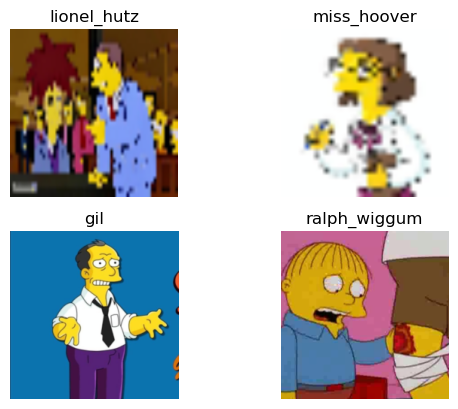

In [75]:
# Run this to test your data loader
images, labels = next(iter(dataloaders['train']))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
imshow(images[0], ax=ax0, normalize=True, title=image_datasets['train'].classes[labels[0]])
imshow(images[1], ax=ax1, normalize=True, title=image_datasets['train'].classes[labels[1]])
imshow(images[2], ax=ax2, normalize=True, title=image_datasets['train'].classes[labels[2]])
imshow(images[3], ax=ax3, normalize=True, title=image_datasets['train'].classes[labels[3]]);

In [76]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, validate=True, verbose=True):
    since = time.time()

    phases = ['train', 'val'] if validate else ['train']
    if verbose:
        print('Phases:', phases)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    param_model_name = str(model_ft.__class__).replace('.', '-')[8:-2]
    with mlflow.start_run(run_name=param_model_name):
        mlflow.log_param('optimizer', param_optimizer)
        mlflow.log_param('lr', param_lr)
#         mlflow.log_param('batch_size', param_bs)
        mlflow.log_param('val_size', VAL_SIZE)
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in phases:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                mlflow.log_metric(f'{phase}_epoch_loss', epoch_loss)
                mlflow.log_metric(f'{phase}_epoch_accuracy', epoch_acc)

                # deep copy the model
                if validate:
                    if phase == 'val' and epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        mlflow.pytorch.log_model(model_ft, artifact_path='models')
                        if verbose:
                            print(f'Saved best val weights.')
                else:
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        mlflow.pytorch.log_model(model_ft, artifact_path='models')
                        if verbose:
                            print(f'Saved best train weights.')
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        mlflow.log_metric('best_accuracy', best_acc)
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [95]:
def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
    
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], ax=ax, title=class_names[preds[j]])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

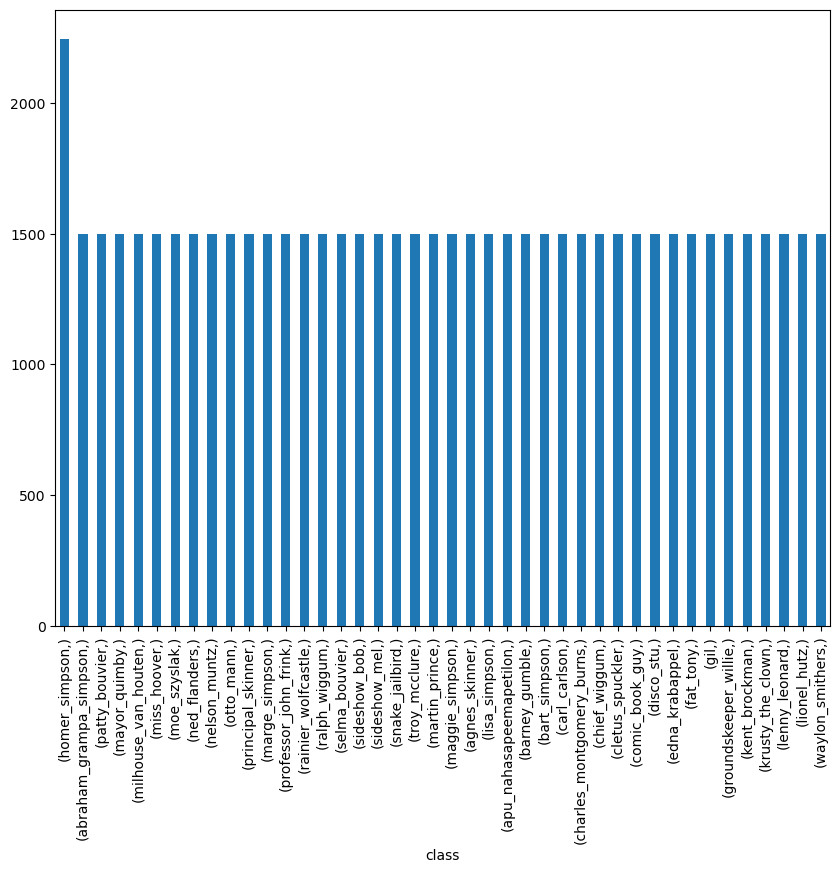

In [78]:
classes = pd.DataFrame(image_datasets['train'].targets, columns=['class']).applymap(lambda x: class_names[x])
plt.figure(figsize=(10,8))
classes.value_counts().plot(kind='bar')

plt.show()

In [79]:
!pip install lion_pytorch --quiet
from lion_pytorch import Lion

In [80]:
LR = 1e-4

model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))
model_ft.to(device)

# Now create the optimizer
criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR) # Adam
optimizer_ft = Lion(model_ft.parameters(), lr=LR, weight_decay=1e-2) # Lion

# # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [81]:
# Hyperparameters to log
param_optimizer = str(optimizer_ft.__class__)[8:-2]
param_lr = optimizer_ft.state_dict()['param_groups'][0]['initial_lr']

In [82]:
def run_mlflow():
    # run tracking UI in the background
    get_ipython().system_raw("mlflow ui --port 5000 --backend-store-uri sqlite:///mlflow.db &") # run tracking UI in the background

    ### run here

    # create remote tunnel using ngrok.com to allow local port access
    # borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

    from pyngrok import ngrok
    # Terminate open tunnels if exist
    ngrok.kill()

    # Setting the authtoken (optional)
    # Get your authtoken from https://dashboard.ngrok.com/auth
    NGROK_AUTH_TOKEN = "2QbvkNkFfJgD1wDiD1gASh53VKq_7PNxKw7RQtSf44Sk6pGUX"
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [83]:
run_mlflow()

WARNI [pyngrok.process.ngrok] t=2023-06-09T14:50:17+0000 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=/root/.config/ngrok/ngrok.yml legacy_path=/root/.ngrok2/ngrok.yml


MLflow Tracking UI: https://51aa-35-189-16-24.ngrok-free.app


2023/06/09 14:50:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/09 14:50:21 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/06/09 14:50:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/09 14:50:21 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
[2023-06-09 14:50:22 +0000] [1294] [INFO] Starting gunicorn 20.1.0
[2023-06-09 14:50:22 +0000] [1294] [INFO] Listening at: http://127.0.0.1:5000 (1294)
[2023-06-09 14:50:22 +0000] [1294] [INFO] Using worker: sync
[2023-06-09 14:50:22 +0000] [1301] [INFO] Booting worker with pid: 1301
[20

In [84]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('resnet18-lion-balanced-augmented-train-data')

<Experiment: artifact_location='/kaggle/working/mlruns/3', creation_time=1686321207613, experiment_id='3', last_update_time=1686321207613, lifecycle_stage='active', name='resnet18-lion-balanced-augmented-train-data', tags={}>

In [87]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                          num_epochs=5, validate=VALIDATE)

Phases: ['train']
Epoch 0/4
----------
train Loss: 0.0066 Acc: 0.9983
Saved best train weights.
Epoch 1/4
----------
train Loss: 0.0053 Acc: 0.9987
Saved best train weights.
Epoch 2/4
----------
train Loss: 0.0059 Acc: 0.9985
Epoch 3/4
----------
train Loss: 0.0058 Acc: 0.9983
Epoch 4/4
----------
train Loss: 0.0049 Acc: 0.9988
Saved best train weights.
Training complete in 20m 28s
Best val Acc: 0.998776


---

Predict

In [88]:
def predict(model, loader):
    with torch.no_grad():
        logits = []
        for inputs in loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
print(val_set[0][0].unsqueeze(0).shape)
print(val_set[0][0].shape)

In [89]:
model_path = '/kaggle/working/mlruns/3/ae40f973bd0144778b79c76515883fb9/artifacts/models/data/model.pth'
model_trained = torch.load(model_path)

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_set[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_trained, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_set[id][1] for id in idxs]

preds_class = [image_datasets['train'].classes[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average="micro")

In [ ]:
# Use trained model to make predictions and compute f1 score
model_path = '/kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/model.pth'

model_trained = torch.load(model_path)
avg_f1 = compute_f1(model_trained, dataloaders['train'])
print('Train f1:', avg_f1)
avg_f1 = compute_f1(model_trained, dataloaders['val'])
print('Validation f1:', avg_f1)

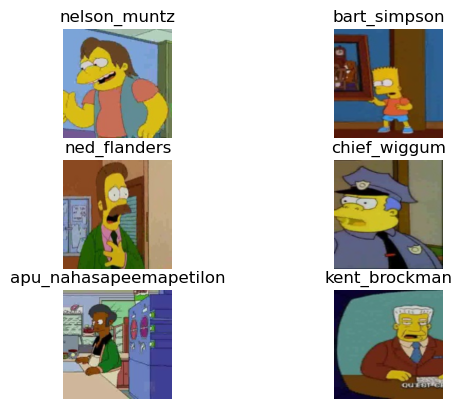

In [97]:
visualize_model(model_trained, test_loader, num_images=6)

In [98]:
test_imgs = []
for i in range(len(image_datasets['test'])):
    test_imgs.append(image_datasets['test'][i][0].unsqueeze(0))

In [99]:
imgs = [item[0].unsqueeze(0) for item in image_datasets['test']]
probs_ims = predict(model_trained, imgs)

In [100]:
y_pred = np.argmax(probs_ims,-1)

preds_class = pd.Series([image_datasets['train'].classes[i] for i in y_pred], name='Expected')
preds_class.head()

0              nelson_muntz
1              bart_simpson
2              ned_flanders
3              chief_wiggum
4    apu_nahasapeemapetilon
Name: Expected, dtype: object

In [102]:
filenames = pd.Series([item[0].replace('./data/test/testset/', '') for item in image_datasets['test'].samples], name='Id')

submission_df = pd.concat((filenames, preds_class), axis=1).set_index('Id')
submission_df.sample(25)

,Expected
Id,
img841.jpg,abraham_grampa_simpson
img131.jpg,sideshow_bob
img103.jpg,edna_krabappel
img497.jpg,milhouse_van_houten
img407.jpg,comic_book_guy
img410.jpg,principal_skinner
img264.jpg,lenny_leonard
img568.jpg,principal_skinner
img548.jpg,homer_simpson


In [103]:
submission_df.to_csv('submission.csv')

In [104]:
# Backup mlruns
!zip -r mlruns.zip /kaggle/working/mlruns

updating: kaggle/working/mlruns/ (stored 0%)
updating: kaggle/working/mlruns/2/ (stored 0%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/ (stored 0%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/ (stored 0%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/ (stored 0%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/conda.yaml (deflated 37%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/requirements.txt (deflated 26%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/ (stored 0%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/pickle_module_info.txt (stored 0%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/model.pth (deflated 7%)
updating: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts